In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('/home/data/APD/COBRA083016_2015.xlsx', sheetname='Query')

### Insight #1 
During class, we isolated the monthly trend of residential burglaries for the year 2015. We could see some clear seasonal changes in the rate of these burglaries.

Perhaps there are also trends for certain crimes based on what day of the week. I would like to look at auto thefts and see if they occur more frequently on particular days.

There is a column in our dataset call 'Avg Day,' which seems to be accurately correlated with the day of the week the crime was reported to occur.

Let's isolate the auto thefts in the dataset and eliminate those that have 'Unknown' days.

In [49]:
auto = df[(df['UC2 Literal'] == 'AUTO THEFT') & (df['Avg Day'] != 'Unk')].groupby('Avg Day').offense_id.count().reset_index()
auto1=auto.reindex([1,5,6,4,0,2,3]).reset_index()
auto1

,index,Avg Day,offense_id
0,1,Mon,575
1,5,Tue,509
2,6,Wed,520
3,4,Thu,505
4,0,Fri,516
5,2,Sat,605
6,3,Sun,642


It was a bit clumsy getting the days in the correct order!

'done'

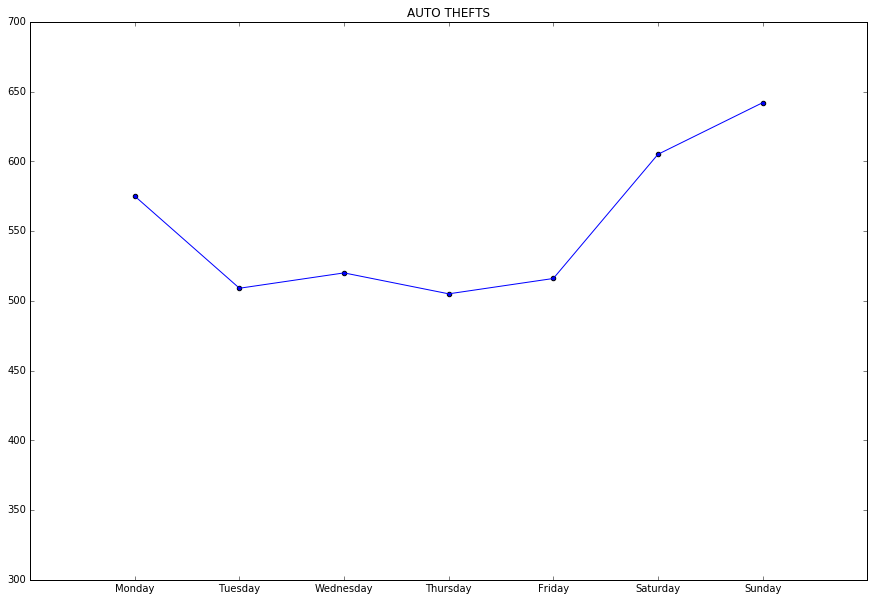

In [58]:
%matplotlib inline
fig = plt.figure(figsize=(15,10)) ## dim in inches
plt.plot(auto1.index, auto1.offense_id)
plt.scatter(auto1.index, auto1.offense_id)
plt.ylim(300, 700)
plt.title('AUTO THEFTS')
plt.xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
#fig.savefig('BurglaryResidence_over_month.svg')
'done'

There is clearly a trend of more auto thefts occuring on the weekend days (perhaps spilling over into early Monday morning), while the weekdays have similar levels of thefts. The jump from Friday into Saturday and Sunday is very easy to spot.

### Insight #2

The dataset also gives us the beat number for each crime. The first digit of this number indicates the zone the crime was committed in. Do certain zones have higher rates of crime?

To organize the crimes by zone, we can round the beat down to the nearest hundred to isolate the zone number. We'll leave out zone 7 (airport) since it's numbers are much smaller.

In [36]:
df['Zone'] = round(df.beat,-2)

zones = df.groupby('Zone').offense_id.count()[0:6]
zones

Zone
100    4548
200    5454
300    4790
400    5212
500    5095
600    4675
Name: offense_id, dtype: int64

'done'

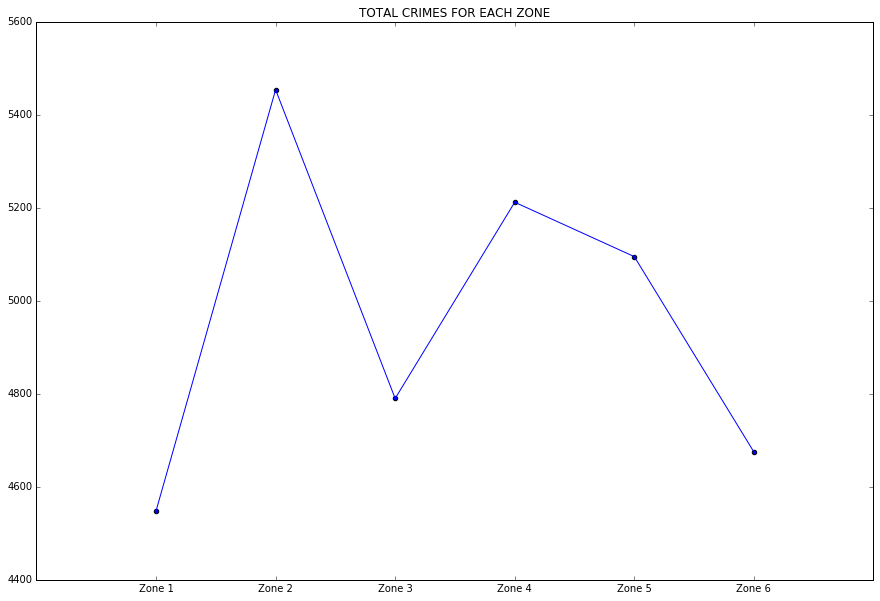

In [70]:
%matplotlib inline
fig = plt.figure(figsize=(15,10)) ## dim in inches
plt.plot([1,2,3,4,5,6], zones)
plt.scatter([1,2,3,4,5,6], zones)
#plt.ylim(3000, 5600)
plt.title('TOTAL CRIMES FOR EACH ZONE')
plt.xticks(range(7), ['','Zone 1','Zone 2','Zone 3','Zone 4','Zone 5','Zone 6'])
'done'

So without controlling for population, it's clear that Zone 2 has the most reported crimes, and Zones 1 & 6 seem to have the lowest total of reported crimes, with Zone 2 having almost 1000 more crimes reported than Zone 1.

### Insight #3

The dataset includes two values for the time of occurence for each crime - an 'occur' time and a 'poss' time. Since the exact time a crime occured is often unknown, a window of time when the crime could have occured must be created. The difference between these two columns in our data should create this window.

Do certain crimes have larger time windows when they could have occured?

In [83]:
df['occur_ts'] = pd.to_datetime(df.occur_date+' '+df.occur_time)
df['poss_ts'] = pd.to_datetime(df.poss_date+' '+df.poss_time)
df[['occur_ts','poss_ts']][1:10]

,occur_ts,poss_ts
207443,2014-12-31 22:00:00,2015-01-01 00:07:00
207444,2015-01-01 00:03:00,2015-01-01 00:03:00
207445,2014-12-31 23:45:00,2015-01-01 00:21:00
207446,2015-01-01 00:30:00,2015-01-01 01:05:00
207447,2014-12-31 21:00:00,2015-01-01 00:15:00
207448,2014-12-31 23:15:00,2015-01-01 01:47:00
207449,2014-12-31 23:00:00,2015-01-01 02:00:00
207450,2015-01-01 02:00:00,2015-01-01 02:03:00
207451,2015-01-01 01:50:00,2015-01-01 02:00:00


In [114]:
df['TimeDelta'] = (df.poss_ts - df.occur_ts).astype('timedelta64[h]')
df2 = df.groupby('UC2 Literal')['TimeDelta'].agg(np.mean).reset_index()
df2


,UC2 Literal,TimeDelta
0,AGG ASSAULT,29.737091
1,AUTO THEFT,42.831955
2,BURGLARY-NONRES,246.780906
3,BURGLARY-RESIDENCE,75.198265
4,LARCENY-FROM VEHICLE,21.584015
5,LARCENY-NON VEHICLE,64.572094
6,RAPE,220.707792
7,ROBBERY-COMMERCIAL,0.348936
8,ROBBERY-PEDESTRIAN,0.686810
9,ROBBERY-RESIDENCE,15.508021


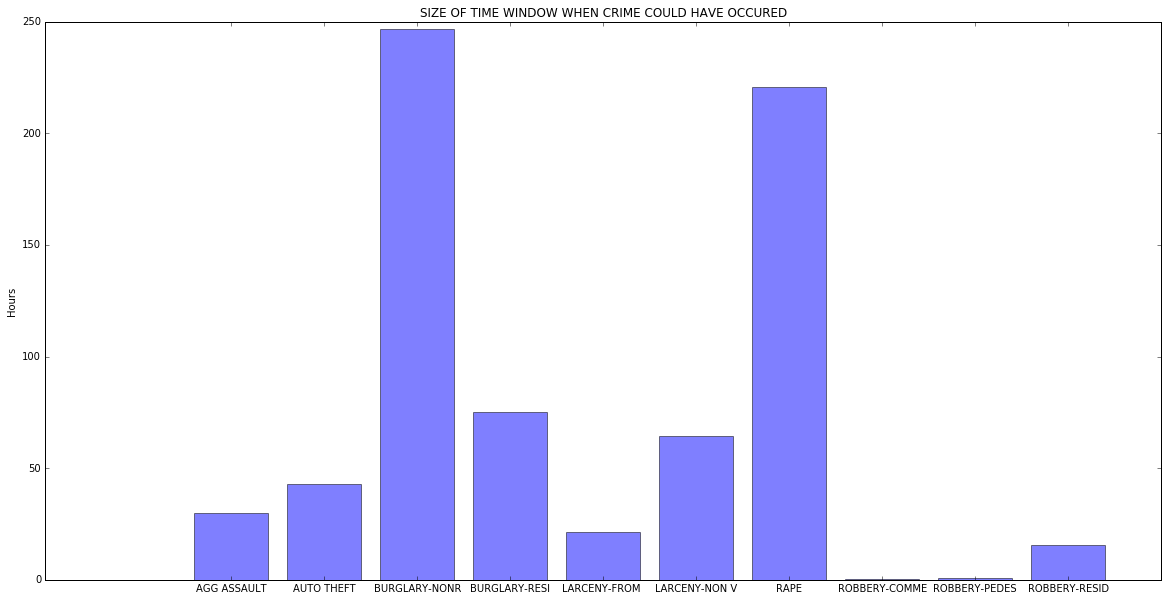

In [112]:
%matplotlib inline
fig = plt.figure(figsize=(20,10)) ## dim in inches
y_pos = np.arange(len(df2['UC2 Literal']))
 
plt.bar(y_pos, df2.TimeDelta, align='center', alpha=0.5)
plt.xticks(y_pos, df2['UC2 Literal'].str[:13])
plt.ylabel('Hours')
plt.title('SIZE OF TIME WINDOW WHEN CRIME COULD HAVE OCCURED')


We clearly have large differences in the way the possible time for different crime types are recorded. The data show some intuitive differences.

For example, since robberies happen directly to the victim, it's fairly easy to know exactly when the crime occured, and we see their windows are small. The same logic follows for assaults. It seems larceny from vehicles is similar, which indicates that most people check their vehicles every day and notice something's gone.

On the other side of the spectrum, non-residential burglaries and rapes have very large windows, about 9-10 days on average. There's some logic with the non-residential burglaries, since missing items may go unnoticed for awhile. But with rapes, it's unclear why the average window is so large. Since we've used the mean time delta value, high outliers may be influencing our value. Also, recordkeeping methods may explain some of the differences we see in the data.


## Part 2

I'm picking aggravated assaults to look at seasonality and annual trends.

In [115]:
data = pd.read_excel('/home/data/APD/COBRA083016.xlsx', sheetname='Query')

In [132]:
assault = data[data['UC2 Literal'] == 'AGG ASSAULT']
assault['occur_ts'] = pd.to_datetime(assault.occur_date+' '+assault.occur_time)
assault['occurmonth'] = assault.occur_ts.map(lambda x : x.month)
assault['occuryear'] = assault.occur_ts.map(lambda x : x.year)
res = assault.groupby(['occuryear','occurmonth']).offense_id.count()
res


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

occuryear  occurmonth
2004.0     2.0             1
2007.0     2.0             1
           3.0             1
2008.0     12.0            4
2009.0     1.0           217
           2.0           203
           3.0           230
           4.0           227
           5.0           223
           6.0           250
           7.0           263
           8.0           198
           9.0           207
           10.0          217
           11.0          182
           12.0          173
2010.0     1.0           179
           2.0           159
           3.0           221
           4.0           228
           5.0           236
           6.0           217
           7.0           255
           8.0           232
           9.0           227
           10.0          244
           11.0          206
           12.0          186
2011.0     1.0           167
           2.0           175
                        ... 
2014.0     3.0           197
           4.0           176
           5.0       

In [168]:
res1 = assault[assault.occuryear.between(2009.0,2015.0,inclusive=True)].groupby('occurmonth')['offense_id'].count()
res1 = res1 / 7
res1

occurmonth
1.0     175.142857
2.0     162.000000
3.0     204.000000
4.0     207.428571
5.0     224.142857
6.0     216.142857
7.0     227.714286
8.0     219.428571
9.0     208.142857
10.0    193.285714
11.0    169.571429
12.0    175.285714
Name: offense_id, dtype: float64

'done'

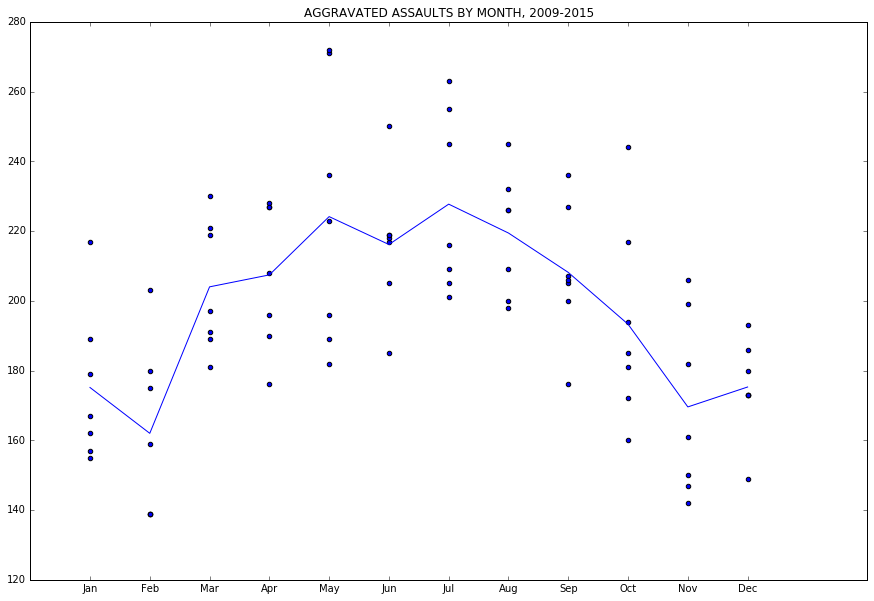

In [171]:
%matplotlib inline
fig = plt.figure(figsize=(15,10)) ## dim in inches
#plt.plot(res[2009.0].index, res[2009.0])
plt.scatter(res[2009.0].index, res[2009.0])
#plt.plot(res[2010.0].index, res[2010.0])
plt.scatter(res[2010.0].index, res[2010.0])
#plt.plot(res[2011.0].index, res[2011.0])
plt.scatter(res[2011.0].index, res[2011.0])
#plt.plot(res[2012.0].index, res[2012.0])
plt.scatter(res[2012.0].index, res[2012.0])
#plt.plot(res[2013.0].index, res[2013.0])
plt.scatter(res[2013.0].index, res[2013.0])
#plt.plot(res[2014.0].index, res[2014.0])
plt.scatter(res[2014.0].index, res[2014.0])
#plt.plot(res[2015.0].index, res[2015.0])
plt.scatter(res[2015.0].index, res[2015.0])
plt.plot(res1.index,res1)
#plt.ylim(0, 500)
plt.title('AGGRAVATED ASSAULTS BY MONTH, 2009-2015')
plt.xticks(range(13), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#fig.savefig('BurglaryResidence_over_month.svg')
'done'

I've plotted the number of aggravated assaults for each month for the years 2009-2015, and included a line for the average of those years. There is clear seasonality shown, with the late spring and summer months far outpacing the winter months for the number of assaults.

In [172]:
res2 = assault[assault.occuryear.between(2009.0,2015.0,inclusive=True)].groupby('occuryear')['offense_id'].count()
res2

occuryear
2009.0    2590
2010.0    2590
2011.0    2515
2012.0    2458
2013.0    2231
2014.0    2183
2015.0    2109
Name: offense_id, dtype: int64

''

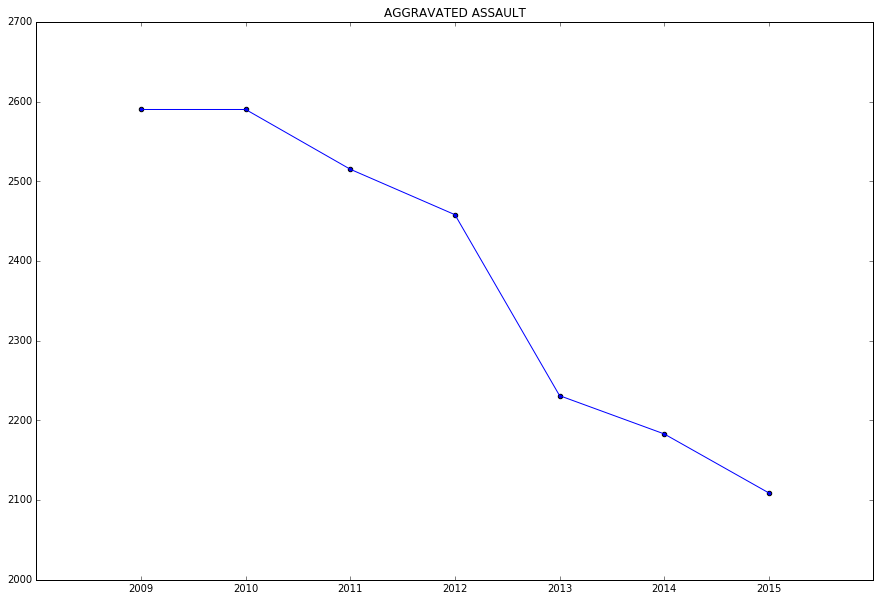

In [188]:
%matplotlib inline
fig = plt.figure(figsize=(15,10)) ## dim in inches
plt.plot(res2.index, res2)
plt.scatter(res2.index, res2)
plt.xticks(range(2009,2016),['2009','2010','2011','2012','2013','2014','2015'])
#plt.ylim(0, 500)
plt.title('AGGRAVATED ASSAULT')
''

As we can see, though, the number of aggraveted assaults has fallen each year since 2009.